# PUTransGCN

## Set up model

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import KFold
from sklearn import metrics
import itertools

class DeepLncLoc(nn.Module):
    def __init__(self, w2v_emb, dropout, merge_win_size, context_size_list, out_size):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(w2v_emb, freeze=False)
        self.dropout = nn.Dropout(dropout)
        self.merge_win = nn.AdaptiveAvgPool1d(merge_win_size)
        assert out_size % len(context_size_list) == 0
        filter_out_size = int(out_size / len(context_size_list))
        self.con_list = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv1d(
                        in_channels=w2v_emb.shape[1],
                        out_channels=filter_out_size,
                        kernel_size=context_size_list[i],
                    ),
                    nn.ReLU(),
                    nn.AdaptiveMaxPool1d(1),
                )
                for i in range(len(context_size_list))
            ]
        )

    def forward(self, p_kmers_id):
        # p_kmers: num_p × all kmers of each p
        x = self.dropout(self.embedding(p_kmers_id))
        x = x.transpose(1, 2)
        x = self.merge_win(x)
        x = [conv(x).squeeze(dim=2) for conv in self.con_list]
        x = torch.cat(x, dim=1)
        return x


class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha

        self.W = nn.Parameter(torch.empty(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.empty(size=(2 * out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, h, adj):
        Wh = torch.mm(h, self.W)
        # h.shape: (N, in_features), Wh.shape: (N, out_features)
        e = self._prepare_attentional_mechanism_input(Wh)

        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, Wh)

        return F.elu(h_prime)

    def _prepare_attentional_mechanism_input(self, Wh):
        Wh1 = torch.matmul(Wh, self.a[: self.out_features, :])
        Wh2 = torch.matmul(Wh, self.a[self.out_features :, :])
        e = Wh1 + Wh2.T
        return self.leakyrelu(e)

    def __repr__(self):
        return (
            self.__class__.__name__
            + " ("
            + str(self.in_features)
            + " -> "
            + str(self.out_features)
            + ")"
        )


class GAT(nn.Module):
    def __init__(
        self,
        p_feat_dim,
        d_feat_dim,
        hidden_dim,
        out_dim,
        dropout,
        alpha,
        nheads,
    ):
        super(GAT, self).__init__()
        self.dropout = dropout
        self.bn_p = nn.BatchNorm1d(p_feat_dim)
        self.bn_d = nn.BatchNorm1d(d_feat_dim)
        self.linear_p = nn.Linear(p_feat_dim, hidden_dim)
        self.linear_d = nn.Linear(d_feat_dim, hidden_dim)
        assert out_dim % nheads == 0
        nhid_per_head = int(out_dim / nheads)
        self.layer1 = [
            GraphAttentionLayer(hidden_dim, nhid_per_head, dropout=dropout, alpha=alpha)
            for _ in range(nheads)
        ]
        for i, head in enumerate(self.layer1):
            self.add_module("layer1_head_{}".format(i), head)

        self.out_att = GraphAttentionLayer(
            nhid_per_head * nheads, out_dim, dropout=dropout, alpha=alpha
        )

    def forward(self, p_feat, d_feat, adj):
        p_feat_hidden = self.linear_p(self.bn_p(p_feat))
        d_feat_hidden = self.linear_d(self.bn_d(d_feat))
        x = torch.cat((p_feat_hidden, d_feat_hidden), dim=0)

        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.cat([att(x, adj) for att in self.layer1], dim=1)

        x = F.dropout(x, self.dropout, training=self.training)
        x = self.out_att(x, adj)
        p_feat = x[: p_feat.shape[0], :]
        d_feat = x[p_feat.shape[0] :, :]
        return p_feat, d_feat


class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))


# @save
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)


def transpose_qkv(X, num_heads):
    X = X.reshape(X.shape[0], num_heads, -1)
    X = X.permute(1, 0, 2)
    return X


def transpose_output(X, num_heads):
    X = X.permute(1, 0, 2)
    return X.reshape(X.shape[0], -1)


def sequence_mask(X, valid_len, value=0):
    maxlen = X.size(1)
    mask = (
        torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :]
        < valid_len[:, None]
    )
    X[~mask] = value
    return X


class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, Q_p, K_p, V_p):
        d = Q_p.shape[-1]
        scores = torch.bmm(Q_p, K_p.transpose(1, 2)) / np.sqrt(d)
        self.attention_weights = nn.functional.softmax(scores, dim=-1)
        return torch.bmm(self.dropout(self.attention_weights), V_p)


class MultiHeadAttention(nn.Module):
    def __init__(
        self,
        q_in_dim,
        kv_in_dim,
        key_size,
        query_size,
        value_size,
        num_heads,
        dropout,
        bias=False,
        **kwargs
    ):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(q_in_dim, query_size, bias=bias)
        self.W_k = nn.Linear(kv_in_dim, key_size, bias=bias)
        self.W_v = nn.Linear(kv_in_dim, value_size, bias=bias)
        self.W_o = nn.Linear(value_size, q_in_dim, bias=bias)

    def forward(self, queries, keys, values):
        Q_p = transpose_qkv(self.W_q(queries), self.num_heads)
        K_p = transpose_qkv(self.W_k(keys), self.num_heads)
        V_p = transpose_qkv(self.W_v(values), self.num_heads)
        output = self.attention(Q_p, K_p, V_p)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)


class EncoderBlock(nn.Module):
    def __init__(
        self,
        q_in_dim,
        kv_in_dim,
        key_size,
        query_size,
        value_size,
        num_heads,
        dropout,
        bias=False,
        **kwargs
    ):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(
            q_in_dim,
            kv_in_dim,
            key_size,
            query_size,
            value_size,
            num_heads,
            dropout,
            bias,
        )
        self.addnorm1 = AddNorm([q_in_dim], dropout)

    def forward(self, queries, keys, values):
        Y = self.addnorm1(queries, self.attention(queries, keys, values))
        return Y


class Encoder(nn.Module):
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, *args):
        raise NotImplementedError


# @save
class TransformerEncoder(Encoder):
    def __init__(
        self,
        q_in_dim,
        kv_in_dim,
        key_size,
        query_size,
        value_size,
        ffn_num_hiddens,
        num_heads,
        num_layers,
        dropout,
        bias=False,
        **kwargs
    ):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                EncoderBlock(
                    q_in_dim,
                    kv_in_dim,
                    key_size,
                    query_size,
                    value_size,
                    num_heads,
                    dropout,
                    bias,
                ),
            )

    def forward(self, p_feat, d_feat, *args):
        Y = p_feat
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            Y = blk(Y, d_feat, d_feat)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return Y


class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter("bias", None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / np.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.mm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return (
            self.__class__.__name__
            + " ("
            + str(self.in_features)
            + " -> "
            + str(self.out_features)
            + ")"
        )


class GCN(nn.Module):
    def __init__(self, p_feat_dim, d_feat_dim, n_hidden, dropout):
        super(GCN, self).__init__()
        self.linear_p = nn.Linear(p_feat_dim, n_hidden)
        self.linear_d = nn.Linear(d_feat_dim, n_hidden)

        self.gc1 = GraphConvolution(n_hidden, n_hidden)
        self.dropout = dropout

    def forward(self, p_feat, d_feat, adj):
        p_feat = self.linear_p(p_feat)
        d_feat = self.linear_d(d_feat)
        x = torch.vstack((p_feat, d_feat))
        x = torch.nn.functional.relu(self.gc1(x, adj))
        x = torch.nn.functional.dropout(x, self.dropout, training=self.training)
        p_feat = x[: p_feat.shape[0], :]
        d_feat = x[p_feat.shape[0] :, :]
        return p_feat, d_feat


class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()

    def forward(self, p_feat, d_feat):
        res = p_feat.mm(d_feat.t())
        return F.sigmoid(res)


class PUTransGCN(nn.Module):
    def __init__(self, deep_lnc_loc, gcn, p_encoder, d_encoder, predictor, **kwargs):
        super(PUTransGCN, self).__init__(**kwargs)
        self.deep_lnc_loc = deep_lnc_loc
        self.gcn = gcn
        self.p_encoder = p_encoder
        self.d_encoder = d_encoder
        self.predictor = predictor

    def forward(self, p_kmers_id, d_feat, adj_mat):
        p_feat_dll = self.deep_lnc_loc(p_kmers_id)
        p_feat_gcn, d_feat_gcn = self.gcn(p_feat_dll, d_feat, adj_mat)
        p_enc_outputs = self.p_encoder(p_feat_gcn, d_feat_gcn)
        d_enc_outputs = self.d_encoder(d_feat_gcn, p_feat_gcn)
        return self.predictor(p_enc_outputs, d_enc_outputs)


In [14]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Function for calculating smith_waterman similarity used in data_processing.py
def matrix(a, b, match_score=3, gap_cost=2):
    H = np.zeros((len(a) + 1, len(b) + 1), int)

    for i, j in itertools.product(range(1, H.shape[0]), range(1, H.shape[1])):
        match = H[i - 1, j - 1] + (
            match_score if a[i - 1] == b[j - 1] else -match_score
        )
        delete = H[i - 1, j] - gap_cost
        insert = H[i, j - 1] - gap_cost
        H[i, j] = max(match, delete, insert, 0)
    return H


def traceback(H, b, b_="", old_i=0):
    # flip H to get index of **last** occurrence of H.max() with np.argmax()
    H_flip = np.flip(np.flip(H, 0), 1)
    i_, j_ = np.unravel_index(H_flip.argmax(), H_flip.shape)
    i, j = np.subtract(
        H.shape, (i_ + 1, j_ + 1)
    )  # (i, j) are **last** indexes of H.max()
    if H[i, j] == 0:
        return b_, j
    b_ = b[j - 1] + "-" + b_ if old_i - i > 1 else b[j - 1] + b_
    return traceback(H[0:i, 0:j], b, b_, i)


def smith_waterman(a, b, match_score=3, gap_cost=2):
    a, b = a.upper(), b.upper()
    H = matrix(a, b, match_score, gap_cost)
    b_, pos = traceback(H, b)
    return pos, pos + len(b_)

# Log datalog
class Logger:
    def __init__(self, total_fold):
        def gen_dict():
            return {
                "epoch": [],
                "f1_score": [],
                "f2_score": [],
                "rank_idx": [],
                "auc": [],
                "aupr": [],
                "threshold": [],
                "recall": [],
                "precision": [],
                "acc": [],
                "specificity": [],
                "mcc": [],
                "train_loss": [],
                "test_loss": [],
            }

        self.df = [gen_dict() for i in range(total_fold)]

    def evaluate(self, true, pred, test_idx):
        labels = true[tuple(list(test_idx.T))].cpu().detach().numpy()
        scores = pred[tuple(list(test_idx.T))].cpu().detach().numpy()

        combined = list(zip(labels, scores))
        combined.sort(key=lambda x: x[1], reverse=True)
        labels_sorted, scores_sorted = zip(*combined)

        indices = np.arange(1, len(labels) + 1)[np.array(labels_sorted) == 1]
        n_test = len(test_idx)
        n_test_p = sum(labels == 1)
        rank_idx = indices.sum() / n_test / n_test_p

        fpr, tpr, thresholds_ = metrics.roc_curve(labels, scores)
        auc = metrics.auc(fpr, tpr)

        precisions, recalls, thresholds = metrics.precision_recall_curve(labels, scores)
        aupr = metrics.auc(recalls, precisions)
        num1 = 2 * recalls * precisions
        den1 = recalls + precisions
        den1[den1 == 0] = 100
        f1_scores = num1 / den1
        f1_score = f1_scores.max()
        beta2 = 2
        num2 = (1 + beta2**2) * recalls * precisions
        den2 = recalls + precisions * beta2**2
        den2[den2 == 0] = 100
        f2_scores = num2 / den2
        f2_score = f2_scores.max()
        f2_score_idx = np.argmax(f2_scores)
        threshold = thresholds[np.argmax(f2_scores)]
        precision = precisions[f2_score_idx]
        recall = recalls[f2_score_idx]
        bi_scores = scores.copy()
        bi_scores[bi_scores < threshold] = 0
        bi_scores[bi_scores >= threshold] = 1
        acc = metrics.accuracy_score(labels, bi_scores)
        tn, fp, fn, tp = metrics.confusion_matrix(labels, bi_scores).ravel()
        specificity = tn / (tn + fp)
        # mcc = metrics.matthews_corrcoef(labels, bi_scores)
        mcc = (tp * tn - fp * fn) / np.sqrt(
            (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
        )
        return tuple(
            np.round(
                [
                    f1_score,
                    f2_score,
                    rank_idx,
                    auc,
                    aupr,
                    threshold,
                    recall,
                    precision,
                    acc,
                    specificity,
                    mcc,
                ],
                6,
            )
        )

    def update(self, fold, epoch, adj, pred, test_idx, train_loss, test_loss, is_print):
        (
            f1_score,
            f2_score,
            rank_idx,
            auc,
            aupr,
            threshold,
            recall,
            precision,
            acc,
            specificity,
            mcc,
        ) = self.evaluate(adj, pred, test_idx)
        self.df[fold]["epoch"].append(epoch)
        self.df[fold]["f1_score"].append(f1_score)
        self.df[fold]["f2_score"].append(f2_score)
        self.df[fold]["rank_idx"].append(rank_idx)
        self.df[fold]["auc"].append(auc)
        self.df[fold]["aupr"].append(aupr)
        self.df[fold]["threshold"].append(threshold)
        self.df[fold]["recall"].append(recall)
        self.df[fold]["precision"].append(precision)
        self.df[fold]["acc"].append(acc)
        self.df[fold]["specificity"].append(specificity)
        self.df[fold]["mcc"].append(mcc)
        if is_print:
            print(
                f"fold:{fold}, epoch:{epoch}, f1: {f1_score}, f2: {f2_score}, rank_idx: {rank_idx}, auc: {auc}, "
                f"aupr: {aupr}, acc: {acc}, specificity: {specificity}, recall: {recall}, mcc: {mcc}"
            )

    def save(self, name):
        with pd.ExcelWriter(f"{name}.xlsx") as writer:
            for fold in range(len(self.df)):
                pd.DataFrame(self.df[fold]).to_excel(
                    writer, sheet_name=f"fold{fold}", index=False
                )


## Load dataset

In [18]:
import pickle
import warnings
warnings.filterwarnings("ignore")

seed_everything(42)
device = torch.device("cuda")

# Load adjacent matrix(data_processing.py)
adj_np = pd.read_csv(r"data\adj.csv", index_col=0).values
# Load piRNA similarity based on Smith-Waterman method(gen_half_p2p_simth.py)
p_sim_np = pd.read_csv(r"data\p2p_smith.csv", index_col=0).values
# Load piRNA feature based on word2vec method(gen_pfeat_gensim.py)
gensim_feat = np.load(
    r"data\gensim_feat_128.npy",
    allow_pickle=True,
).flat[0]
p_kmers_emb = gensim_feat["p_kmers_emb"]
pad_kmers_id_seq = gensim_feat["pad_kmers_id_seq"]
# Load disease similarity based on DO DAG(gen_d2d_do.py)
d_sim_np = pd.read_csv(r"data\d2d_do.csv", index_col=0).values
d_feat = d_sim_np

num_p, num_d = adj_np.shape

In [20]:
p_sim = torch.FloatTensor(p_sim_np).to(device)
d_sim = torch.FloatTensor(d_sim_np).to(device)
adj = torch.FloatTensor(adj_np).to(device)
p_kmers_emb = torch.FloatTensor(p_kmers_emb).to(device)
pad_kmers_id_seq = torch.tensor(pad_kmers_id_seq).to(device)
d_feat = torch.FloatTensor(d_feat).to(device)

In [21]:
k = 1
merge_win_size = 32
context_size_list = [1, 3, 5]
dll_out_size = 128 * len(context_size_list) * k

gcn_out_dim = 256 * k
gcn_hidden_dim = 256 * k
num_layers, dropout = 1, 0.4

query_size = key_size = 256 * k
value_size = 256 * k
enc_ffn_num_hiddens, n_enc_heads = 256, 2 * k

lr, num_epochs = 0.001, 200

feat_init_d = d_feat.shape[1]
logger = Logger(5)

# Train

In [11]:
class MaskedBCELoss(nn.BCELoss):
    def forward(self, pred, adj, train_mask, test_mask):
        self.reduction = "none"
        unweighted_loss = super(MaskedBCELoss, self).forward(pred, adj)
        train_loss = (unweighted_loss * train_mask).sum()
        test_loss = (unweighted_loss * test_mask).sum()
        return train_loss, test_loss


def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm


def fit(
    fold_cnt,
    model,
    adj,
    adj_full,
    pad_kmers_id_seq,
    d_feat,
    train_mask,
    test_mask,
    lr,
    num_epochs,
):
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)

    model.apply(xavier_init_weights)
    # optimizer = torch.optim.RMSprop(net.parameters(), lr, 0.9)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = MaskedBCELoss()

    test_idx = torch.argwhere(test_mask == 1)
    # test_idx = torch.argwhere(torch.ones_like(test_mask) == 1)
    for epoch in range(num_epochs):
        # for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        pred = model(pad_kmers_id_seq, d_feat, adj_full)
        train_loss, test_loss = loss(pred, adj, train_mask, test_mask)
        train_loss.backward()
        grad_clipping(model, 1)
        optimizer.step()

        model.eval()
        pred = model(pad_kmers_id_seq, d_feat, adj_full)

        scores = pred[tuple(list(test_idx.T))].cpu().detach().numpy()
        # print(len(set(scores)))
        # np.save(rf".\scores\f{fold_cnt}_e{epoch}_scores.npy", scores)
        logger.update(
            fold_cnt, epoch, adj, pred, test_idx, train_loss.item(), test_loss.item(), is_print=((num_epochs-1)==epoch)
        )

    return pred


In [12]:
with open(r"data/fold_info.pickle", "rb") as f:
    fold_info = pickle.load(f)
with open(rf"PUTransGCN_spy/rn_ij_list_5.pickle", "rb") as f:
    rn_ij_list_spy = pickle.load(f)
with open(rf"PUTransGCN_pu_bagging\rn_ij_list.pickle", "rb") as f:
    rn_ij_list_pu = pickle.load(f)
with open(rf"PUTransGCN_two_step\rn_ij_list.pickle", "rb") as f:
    rn_ij_list_two = pickle.load(f)

pos_train_ij_list = fold_info["pos_train_ij_list"]
pos_test_ij_list = fold_info["pos_test_ij_list"]
unlabelled_train_ij_list = fold_info["unlabelled_train_ij_list"]
unlabelled_test_ij_list = fold_info["unlabelled_test_ij_list"]
p_gip_list = fold_info["p_gip_list"]
d_gip_list = fold_info["d_gip_list"]

In [22]:
for i in range(5):
    # print(f"fold {i}")
    pos_train_ij = pos_train_ij_list[i]
    pos_test_ij = pos_test_ij_list[i]
    unlabelled_train_ij = unlabelled_train_ij_list[i]
    unlabelled_test_ij = unlabelled_test_ij_list[i]
    p_gip = p_gip_list[i]
    d_gip = d_gip_list[i]
    rn_ij = np.concatenate((rn_ij_list_spy[i], rn_ij_list_pu[i], rn_ij_list_two[i]))


    A_corner_np = np.zeros_like(adj_np)
    A_corner_np[tuple(list(pos_train_ij.T))] = 1

    A_np = np.concatenate(
        (
            np.concatenate(((p_sim_np + p_gip) / 2, A_corner_np), axis=1),
            np.concatenate(((A_corner_np).T, (d_sim_np + d_gip) / 2), axis=1),
        ),
        axis=0,
    )

    # train_mask_np = np.ones_like(adj_np)
    train_mask_np = np.zeros_like(adj_np)
    train_mask_np[tuple(list(pos_train_ij.T))] = 1
    # train_mask_np[tuple(list(unlabelled_train_ij.T))] = 1
    train_mask_np[tuple(list(rn_ij.T))] = 1

    test_mask_np = np.zeros_like(adj_np)
    test_mask_np[tuple(list(pos_test_ij.T))] = 1
    test_mask_np[tuple(list(unlabelled_test_ij.T))] = 1

    A_corner = torch.FloatTensor(A_corner_np).to(device)
    A = torch.FloatTensor(A_np).to(device)
    train_mask = torch.FloatTensor(train_mask_np).to(device)
    test_mask = torch.FloatTensor(test_mask_np).to(device)

    torch.cuda.empty_cache()
    deep_lnc_loc = DeepLncLoc(
        p_kmers_emb, dropout, merge_win_size, context_size_list, dll_out_size
    ).to(device)

    gcn = GCN(
        p_feat_dim=dll_out_size,
        d_feat_dim=feat_init_d,
        n_hidden=gcn_hidden_dim,
        dropout=dropout,
    ).to(device)

    p_encoder = TransformerEncoder(
        q_in_dim=gcn_out_dim,
        kv_in_dim=gcn_out_dim,
        key_size=key_size,
        query_size=query_size,
        value_size=value_size,
        ffn_num_hiddens=enc_ffn_num_hiddens,
        num_heads=n_enc_heads,
        num_layers=num_layers,
        dropout=dropout,
        bias=False,
    ).to(device)

    d_encoder = TransformerEncoder(
        q_in_dim=gcn_out_dim,
        kv_in_dim=gcn_out_dim,
        key_size=key_size,
        query_size=query_size,
        value_size=value_size,
        ffn_num_hiddens=enc_ffn_num_hiddens,
        num_heads=n_enc_heads,
        num_layers=num_layers,
        dropout=dropout,
        bias=False,
    ).to(device)

    predictor = Predictor().to(device)

    model = PUTransGCN(deep_lnc_loc, gcn, p_encoder, d_encoder, predictor).to(device)
    pred = fit(
        i,
        model,
        adj,
        A,
        pad_kmers_id_seq,
        d_feat,
        train_mask,
        test_mask,
        lr,
        num_epochs,
    )
    max_allocated_memory = torch.cuda.max_memory_allocated()
    print(f"max_allocated_memory: {max_allocated_memory / 1024 ** 2} MB")

# logger.save("PUTransGCN_comb5")


fold:0, epoch:199, f1: 0.570349, f2: 0.720557, rank_idx: 0.096624, auc: 0.936678, aupr: 0.591308, acc: 0.882168, specificity: 0.879385, recall: 0.915308, mcc: 0.550424
max_allocated_memory: 4139.74609375 MB
fold:1, epoch:199, f1: 0.523901, f2: 0.712631, rank_idx: 0.114842, auc: 0.914692, aupr: 0.652763, acc: 0.867699, specificity: 0.861757, recall: 0.938453, mcc: 0.534602
max_allocated_memory: 4139.74609375 MB
fold:2, epoch:199, f1: 0.553076, f2: 0.726041, rank_idx: 0.101504, auc: 0.931277, aupr: 0.580399, acc: 0.884365, specificity: 0.881417, recall: 0.919474, mcc: 0.55648
max_allocated_memory: 4139.74609375 MB
fold:3, epoch:199, f1: 0.579916, f2: 0.732476, rank_idx: 0.097522, auc: 0.935791, aupr: 0.585863, acc: 0.889455, specificity: 0.887112, recall: 0.917368, mcc: 0.56569
max_allocated_memory: 4139.74609375 MB
fold:4, epoch:199, f1: 0.578709, f2: 0.710483, rank_idx: 0.098794, auc: 0.934869, aupr: 0.609316, acc: 0.876085, specificity: 0.872973, recall: 0.913158, mcc: 0.537917
max_al

# Result

Run `main.py` in each model folder to obtain their results, and run `result_compare.py` to obtain the comparison result.

In [4]:
import matplotlib.pyplot as plt

df = pd.read_excel("result_compare.xlsx", sheet_name="all_result", index_col=0)
result = df[["rank_idx", "auc", "aupr"]]

In [5]:
result

,rank_idx,auc,aupr
ETGPDA,0.116±0.018,0.916±0.02,0.417±0.148
iPiDA-GBNN,0.153±0.01,0.879±0.014,0.461±0.114
GCN,0.145±0.057,0.885±0.062,0.427±0.04
SWGCN,0.113±0.004,0.92±0.004,0.468±0.015
dt,0.444±0.021,0.569±0.026,0.117±0.008
rf,0.238±0.016,0.784±0.018,0.165±0.009
svm,0.292±0.01,0.725±0.011,0.133±0.006
piRDA,0.12±0.003,0.912±0.004,0.338±0.007
PUTransGCN_all,0.119±0.042,0.913±0.045,0.522±0.148
PUTransGCN_comb_5,0.103±0.006,0.93±0.007,0.598±0.032


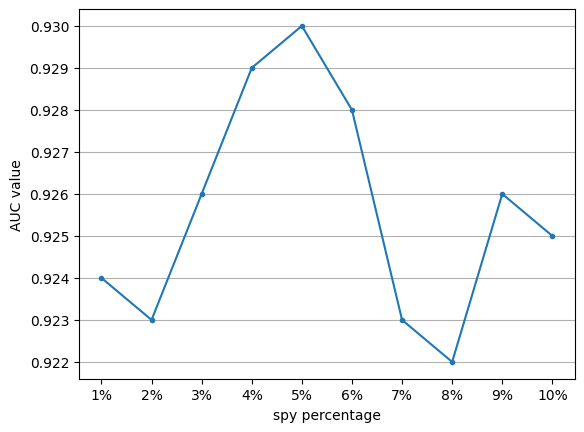

In [6]:
auc_list_str = result.loc[[f"PUTransGCN_comb_{i}" for i in range(1, 11)]][
    "auc"
].tolist()
auc_list = [float(x.split("±")[0]) for x in auc_list_str]
plt.plot(range(1, 11), auc_list, marker=".")
plt.xticks(range(1, 11), [f"{i}%" for i in range(1, 11)])
plt.xlabel("spy percentage")
plt.ylabel("AUC value")
plt.grid(axis="y")
#plt.savefig("spy_percent")

plt.show()